# Système de Recommandation - MVP

**Objectif** : Construire un système de recommandation qui, pour un `user_id`, retourne 5 articles recommandés.

**Approches testées** :
1. Baseline : Top articles globaux (popularité)
2. Content-based : Similarité cosinus sur embeddings
3. Collaborative Filtering : Surprise (SVD/KNN) et implicit (ALS)

**Métriques d'évaluation** : Precision@5, Recall@5, MAP@5, Hit-rate@5


## 1. Import des bibliothèques


In [ ]:
# Import des libraries
import pandas as pd
import numpy as np
from pathlib import Path
import os
import pickle
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


## 2. Chargement des données


In [ ]:
def load_data():
    '''
    Fonction utilisée pour charger les données du site "News Portal" de Globo.com
    
    Retourne :
        articles (dataframe) : métadonnées des articles (id, catégorie, date de publication, nombre de mots)
        embeddings (array) : matrice de 250 vecteurs décrivant les articles
        clicks (dataframe) : interactions utilisateurs ou clics sur les articles
    '''
    # Charger les métadonnées des articles
    articles = pd.read_csv('articles_metadata.csv')
    # Supprimer la colonne inutile
    articles.drop(columns=['publisher_id'], inplace=True)
    # Convertir tous les types de données en entier
    articles = articles.astype(np.int64)

    # Charger les embeddings des articles
    with open('articles_embeddings.pickle', 'rb') as file:
        embeddings = pickle.load(file)
    # Convertir les types de float64 à float32
    embeddings = np.array(embeddings).astype(np.float32)
    
    clicks_list = []
    # Charger les fichiers d'interactions utilisateurs avec les articles
    for file in sorted(os.listdir("clicks/")):
        clicks_list.append(pd.read_csv("clicks/"+file))
    clicks = pd.concat(clicks_list, ignore_index=True)
    # Renommer la colonne pour homogénéiser les noms
    clicks.rename(columns={'click_article_id':'article_id'}, inplace=True)
    # Supprimer les colonnes inutiles
    clicks.drop(columns=['click_environment', 'click_deviceGroup', 'click_os', 
                        'click_country', 'click_region', 'click_referrer_type'], inplace=True)
    # Convertir tous les types de données en entier
    clicks = clicks.astype(np.int64)

    return articles, embeddings, clicks

# Appeler la fonction pour charger les données
articles, embeddings, clicks = load_data()

# Afficher les dimensions des jeux de données
print("Shape du DataFrame articles : ", articles.shape)
print("Shape de la matrice d'embeddings : ", embeddings.shape)
print("Shape du DataFrame clicks : ", clicks.shape)


Articles Dataframe shape:  (364047, 4)
Embedding Matrix shape:  (364047, 250)
Clicks Dataframe shape:  (2988181, 6)


In [31]:
articles

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
...,...,...,...,...
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126


In [32]:
embeddings

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

Explication des champs clikcs :
- user_id: the unique identifier of the user
- session_id: the unique identifier of the session; in a session, a user may have consulted several articles
- session_start: the timestamp of the 1st interaction of the session
- session_size: the number of interactions during the session
- article_id: the article viewed by the user
- click_timestamp: the timestamp of the interaction

In [30]:
clicks

,user_id,session_id,session_start,session_size,article_id,click_timestamp
0,0,1506825423271737,1506825423000,2,157541,1506826828020
1,0,1506825423271737,1506825423000,2,68866,1506826858020
2,1,1506825426267738,1506825426000,2,235840,1506827017951
3,1,1506825426267738,1506825426000,2,96663,1506827047951
4,2,1506825435299739,1506825435000,2,119592,1506827090575
...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583


In [39]:
# Utilisateurs uniques
print(f"Nombre d'utilisateurs uniques: {clicks.user_id.nunique():,}")
pd.Series(clicks.user_id.unique())
clicks.groupby('user_id').size()

Nombre d'utilisateurs uniques: 322,897


user_id
0          8
1         12
2          4
3         17
4          7
          ..
322892     2
322893     2
322894     2
322895     2
322896     2
Length: 322897, dtype: int64

## 3. Exploration du dataset


In [3]:
# Statistiques de base
print("=== STATISTIQUES GÉNÉRALES ===")
print(f"Nombre d'utilisateurs uniques: {clicks.user_id.nunique():,}")
print(f"Nombre d'articles uniques: {articles.article_id.nunique():,}")
print(f"Nombre d'articles lus par les utilisateurs: {clicks.article_id.nunique():,}")
print(f"Nombre total d'interactions: {len(clicks):,}")
print(f"Nombre de sessions uniques: {clicks.session_id.nunique():,}")

# Sparsité de la matrice user-item
n_users = clicks.user_id.nunique()
n_items = clicks.article_id.nunique()
n_interactions = len(clicks)
sparsity = 1 - (n_interactions / (n_users * n_items))
print(f"\nSparsité de la matrice user-item: {sparsity:.4%}")
print(f"Taux de remplissage: {(1-sparsity):.4%}")


=== STATISTIQUES GÉNÉRALES ===
Nombre d'utilisateurs uniques: 322,897
Nombre d'articles uniques: 364,047
Nombre d'articles lus par les utilisateurs: 46,033
Nombre total d'interactions: 2,988,181
Nombre de sessions uniques: 1,048,594

Sparsité de la matrice user-item: 99.9799%
Taux de remplissage: 0.0201%


In [4]:
# Distribution des interactions par utilisateur
interactions_per_user = clicks.groupby('user_id').size()
print("\n=== DISTRIBUTION DES INTERACTIONS PAR UTILISATEUR ===")
print(f"Moyenne: {interactions_per_user.mean():.2f}")
print(f"Médiane: {interactions_per_user.median():.2f}")
print(f"Min: {interactions_per_user.min()}")
print(f"Max: {interactions_per_user.max()}")
print(f"Q1: {interactions_per_user.quantile(0.25):.2f}")
print(f"Q3: {interactions_per_user.quantile(0.75):.2f}")

# Distribution des interactions par article
interactions_per_article = clicks.groupby('article_id').size()
print("\n=== DISTRIBUTION DES INTERACTIONS PAR ARTICLE ===")
print(f"Moyenne: {interactions_per_article.mean():.2f}")
print(f"Médiane: {interactions_per_article.median():.2f}")
print(f"Min: {interactions_per_article.min()}")
print(f"Max: {interactions_per_article.max()}")
print(f"Q1: {interactions_per_article.quantile(0.25):.2f}")
print(f"Q3: {interactions_per_article.quantile(0.75):.2f}")



=== DISTRIBUTION DES INTERACTIONS PAR UTILISATEUR ===
Moyenne: 9.25
Médiane: 4.00
Min: 2
Max: 1232
Q1: 2.00
Q3: 10.00

=== DISTRIBUTION DES INTERACTIONS PAR ARTICLE ===
Moyenne: 64.91
Médiane: 1.00
Min: 1
Max: 37213
Q1: 1.00
Q3: 6.00



=== TOP 20 ARTICLES LES PLUS POPULAIRES ===
article_id
160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
336223    21855
96210     21577
162655    21062
183176    20303
168623    19526
331116    18788
158536    18646
64329     18618
199198    17221
272660    16175
235616    15443
233717    15390
336245    15046
336220    14752
156560    14417
dtype: int64


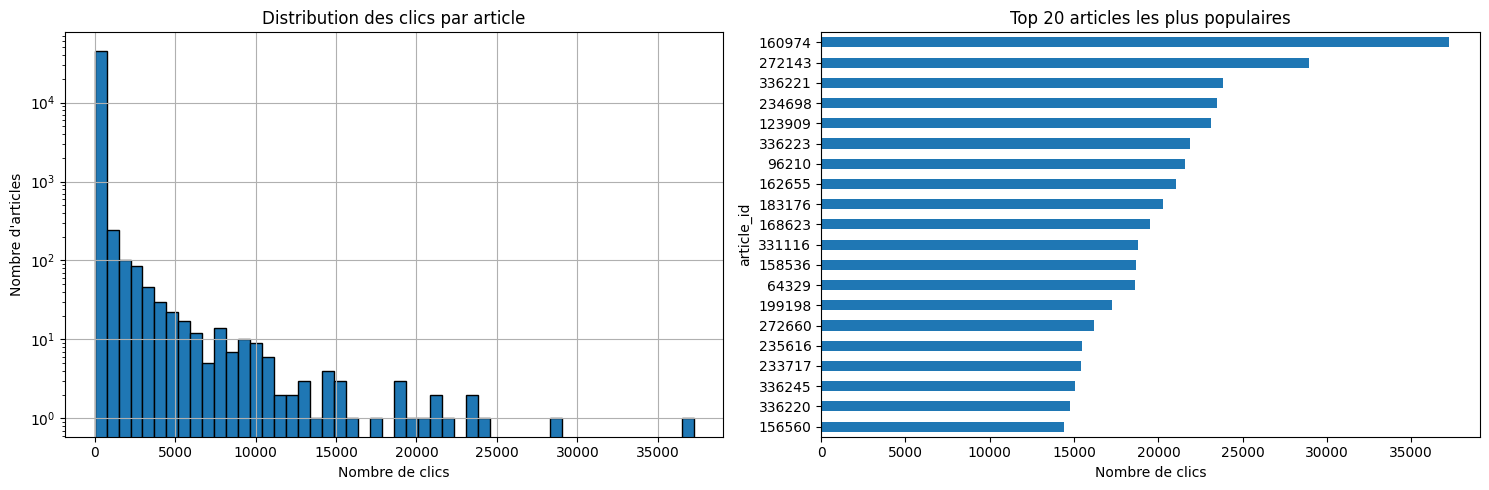

In [5]:
# Top articles les plus populaires
top_articles = clicks.groupby('article_id').size().sort_values(ascending=False).head(20)
print("\n=== TOP 20 ARTICLES LES PLUS POPULAIRES ===")
print(top_articles)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution des clics par article (log scale)
interactions_per_article.hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Nombre de clics')
axes[0].set_ylabel('Nombre d\'articles')
axes[0].set_title('Distribution des clics par article')
axes[0].set_yscale('log')

# Top 20 articles
top_articles.plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Nombre de clics')
axes[1].set_title('Top 20 articles les plus populaires')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


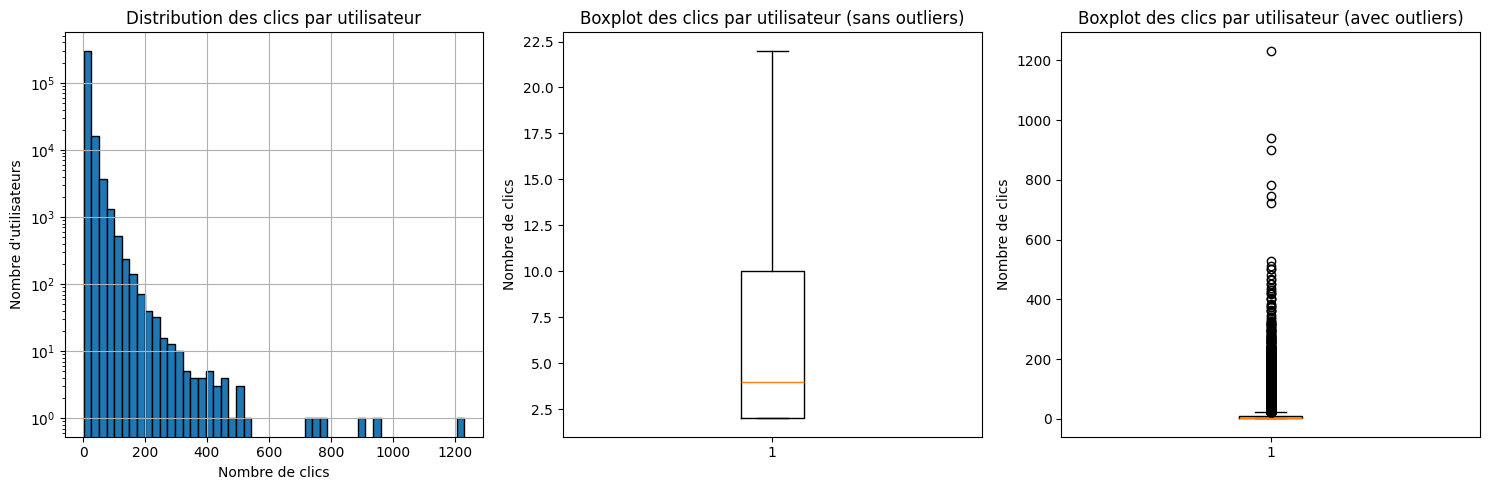

In [50]:
# Distribution des clics par utilisateur
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogramme
interactions_per_user.hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Nombre de clics')
axes[0].set_ylabel('Nombre d\'utilisateurs')
axes[0].set_title('Distribution des clics par utilisateur')
axes[0].set_yscale('log')

# Boxplot
axes[1].boxplot(interactions_per_user.values, showfliers=False) # False pour enlever les outliers basé sur IQR = Q3-Q1 et LimitHigh = Q3+1.5*IQR et LimitLow = Q1-1.5*IQR
axes[1].set_ylabel('Nombre de clics')
axes[1].set_title('Boxplot des clics par utilisateur (sans outliers)')

# Boxplot
axes[2].boxplot(interactions_per_user.values, showfliers=True) 
axes[2].set_ylabel('Nombre de clics')
axes[2].set_title('Boxplot des clics par utilisateur (avec outliers)')

plt.tight_layout()
plt.show()


## 4. Préparation des données pour l'évaluation


In [ ]:
# Créer une matrice d'interactions user-item (compte des interactions pour chaque utilisateur et article)
interactions = clicks.groupby(['user_id', 'article_id']).size().reset_index(name='count')

# Séparer train/test (stratifié par utilisateur pour avoir des utilisateurs dans les deux sets)
# On garde 80% des interactions pour l'entraînement
train_interactions, test_interactions = train_test_split(
    interactions, 
    test_size=0.2, 
    random_state=42,
    stratify=interactions['user_id']
)

print(f"Train interactions: {len(train_interactions):,}")
print(f"Test interactions: {len(test_interactions):,}")

# S'assurer que tous les utilisateurs du test sont dans le train
test_users = set(test_interactions['user_id'].unique())
train_users = set(train_interactions['user_id'].unique())
print(f"\nUtilisateurs dans le train: {len(train_users):,}")
print(f"Utilisateurs dans le test: {len(test_users):,}")
print(f"Utilisateurs du test présents dans le train: {len(test_users & train_users):,}")

# Créer un dictionnaire pour l'évaluation : {user_id: [list of article_ids]}
test_user_items = test_interactions.groupby('user_id')['article_id'].apply(list).to_dict()


Train interactions: 2,360,568
Test interactions: 590,142

Utilisateurs dans le train: 322,897
Utilisateurs dans le test: 222,861
Utilisateurs du test présents dans le train: 222,861


In [47]:
interactions

,user_id,article_id,count
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


## 5. Fonctions d'évaluation


In [8]:
def precision_at_k(recommended, relevant, k=5):
    """Calcule Precision@k"""
    if len(recommended) == 0:
        return 0.0
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum(1 for item in recommended_k if item in relevant_set)
    return hits / min(k, len(recommended))

def recall_at_k(recommended, relevant, k=5):
    """Calcule Recall@k"""
    if len(relevant) == 0:
        return 0.0
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum(1 for item in recommended_k if item in relevant_set)
    return hits / len(relevant)

def ap_at_k(recommended, relevant, k=5):
    """Calcule Average Precision@k"""
    if len(relevant) == 0:
        return 0.0
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    
    hits = 0
    precision_sum = 0.0
    for i, item in enumerate(recommended_k, 1):
        if item in relevant_set:
            hits += 1
            precision_sum += hits / i
    return precision_sum / min(len(relevant), k)

def map_at_k(all_recommended, all_relevant, k=5):
    """Calcule Mean Average Precision@k"""
    if len(all_recommended) == 0:
        return 0.0
    ap_scores = [ap_at_k(rec, rel, k) for rec, rel in zip(all_recommended, all_relevant)]
    return np.mean(ap_scores)

def hit_rate_at_k(all_recommended, all_relevant, k=5):
    """Calcule Hit Rate@k (fraction d'utilisateurs avec au moins 1 hit)"""
    if len(all_recommended) == 0:
        return 0.0
    hits = 0
    for recommended, relevant in zip(all_recommended, all_relevant):
        recommended_k = recommended[:k]
        relevant_set = set(relevant)
        if any(item in relevant_set for item in recommended_k):
            hits += 1
    return hits / len(all_recommended)

def evaluate_model(recommendations_dict, test_user_items, k=5):
    """
    Évalue un modèle de recommandation
    
    Args:
        recommendations_dict: dict {user_id: [list of recommended article_ids]}
        test_user_items: dict {user_id: [list of relevant article_ids]}
        k: nombre de recommandations à considérer
    
    Returns:
        dict avec les métriques
    """
    all_recommended = []
    all_relevant = []
    
    # Filtrer pour ne garder que les utilisateurs présents dans les deux
    common_users = set(recommendations_dict.keys()) & set(test_user_items.keys())
    
    for user_id in common_users:
        all_recommended.append(recommendations_dict[user_id])
        all_relevant.append(test_user_items[user_id])
    
    if len(all_recommended) == 0:
        return {
            'precision@k': 0.0,
            'recall@k': 0.0,
            'map@k': 0.0,
            'hit_rate@k': 0.0,
            'n_users': 0
        }
    
    # Calculer les métriques
    precisions = [precision_at_k(rec, rel, k) for rec, rel in zip(all_recommended, all_relevant)]
    recalls = [recall_at_k(rec, rel, k) for rec, rel in zip(all_recommended, all_relevant)]
    
    results = {
        'precision@k': np.mean(precisions),
        'recall@k': np.mean(recalls),
        'map@k': map_at_k(all_recommended, all_relevant, k),
        'hit_rate@k': hit_rate_at_k(all_recommended, all_relevant, k),
        'n_users': len(all_recommended)
    }
    
    return results


## 6. Baseline - Popularité

In [9]:
def get_popularity_recommendations(train_interactions, n_reco=5):
    """
    Retourne les n_reco articles les plus populaires basés sur le nombre de clics
    """
    top_articles = train_interactions.groupby('article_id')['count'].sum().sort_values(ascending=False)
    return top_articles.head(n_reco).index.tolist()

# Générer les recommandations pour tous les utilisateurs du test
popularity_recommendations = get_popularity_recommendations(train_interactions, n_reco=5)
print(f"Top 5 articles populaires: {popularity_recommendations}")

# Créer un dictionnaire de recommandations (même recommandation pour tous les utilisateurs)
popularity_recommendations_dict = {
    user_id: popularity_recommendations 
    for user_id in test_user_items.keys()
}

# Évaluer le modèle
popularity_results = evaluate_model(popularity_recommendations_dict, test_user_items, k=5)
print("\n=== RÉSULTATS MODÈLE BASELINE (POPULARITÉ) ===")
for metric, value in popularity_results.items():
    print(f"{metric}: {value:.4f}")


Top 5 articles populaires: [160974, 272143, 336221, 234698, 123909]

=== RÉSULTATS MODÈLE BASELINE (POPULARITÉ) ===
precision@k: 0.0233
recall@k: 0.0511
map@k: 0.0280
hit_rate@k: 0.1099
n_users: 222861.0000


## 7. Modèle Content-Based : Similarité Cosinus sur Embeddings


In [62]:
# VERSION ULTRA-OPTIMISÉE : Calcul en batch pour tous les utilisateurs
print("Préparation du mapping article_id -> index...")
all_article_ids = articles['article_id'].values

# Vérifier l'alignement embeddings <-> articles
if len(embeddings) != len(articles):
    raise ValueError(f"Mismatch embeddings/articles: {len(embeddings)} vs {len(articles)}")

is_aligned = np.array_equal(all_article_ids, np.arange(len(articles)))
if is_aligned:
    article_to_idx = {int(aid): int(aid) for aid in all_article_ids}
    print("✅ Alignement vérifié: article_id correspond à l'index des embeddings.")
else:
    article_to_idx = {aid: idx for idx, aid in enumerate(all_article_ids)}
    print("⚠️ Alignement non trivial: mapping explicite créé.")

print("Préparation des catégories d'articles...")
article_id_to_category = dict(zip(articles['article_id'].values, articles['category_id'].values))
category_to_article_ids = (
    articles.groupby('category_id')['article_id']
    .apply(lambda s: s.values)
    .to_dict()
)
category_to_indices = {
    cat: [article_to_idx[int(aid)] for aid in ids if int(aid) in article_to_idx]
    for cat, ids in category_to_article_ids.items()
}

# Préparer les données utilisateur une seule fois
print("Préparation des profils utilisateur...")
user_articles_dict = train_interactions.groupby('user_id')['article_id'].apply(set).to_dict()
user_article_counts = train_interactions.groupby(['user_id', 'article_id'])['count'].sum()

# Normaliser les embeddings
from sklearn.preprocessing import normalize
embeddings_normalized = normalize(embeddings, norm='l2')

# Créer les profils utilisateur pour tous les utilisateurs en batch
print("Calcul des profils utilisateur (moyenne pondérée des embeddings)...")
start_time = time()
user_profiles = {}
user_read_articles = {}

for user_id, article_set in user_articles_dict.items():
    if len(article_set) == 0:
        continue

    # Récupérer les indices des articles lus
    user_indices = []
    user_article_ids = []
    for article_id in article_set:
        idx = article_to_idx.get(article_id)
        if idx is not None and idx < len(embeddings_normalized):
            user_indices.append(idx)
            user_article_ids.append(article_id)

    if len(user_indices) > 0:
        # Calculer le profil utilisateur (moyenne pondérée des embeddings normalisés)
        user_embeddings = embeddings_normalized[user_indices]
        weights = [float(user_article_counts.get((user_id, aid), 1.0)) for aid in user_article_ids]
        if not any(weights):
            weights = None
        user_profile = np.average(user_embeddings, axis=0, weights=weights)
        user_profiles[user_id] = normalize(user_profile.reshape(1, -1), norm='l2')[0]
        user_read_articles[user_id] = article_set

print(f"Profils calculés pour {len(user_profiles)} utilisateurs en {time() - start_time:.1f}s")

# Générer les recommandations pour tous les utilisateurs du test
print("\nGénération des recommandations content-based (version batch ultra-optimisée)...")
start_time = time()
content_based_recommendations_dict = {}

# Traiter TOUS les utilisateurs pour une comparaison équitable
USE_FULL_DATASET = True  # Traiter tous les utilisateurs du test
sample_size = len(test_user_items) if USE_FULL_DATASET else min(5000, len(test_user_items))
test_user_ids_sample = list(test_user_items.keys())[:sample_size]

total_batches = (len(test_user_ids_sample) - 1) // 100 + 1
print(f"Traitement de {sample_size:,} utilisateurs en {total_batches} batchs de 100...")
print(f"Estimation initiale: ~{sample_size * 0.024 / 60:.1f} minutes (basé sur ~0.024s/utilisateur)")

# Calculer les similarités en batch pour plusieurs utilisateurs à la fois
batch_size = 100  # Traiter 100 utilisateurs à la fois

for batch_start in range(0, len(test_user_ids_sample), batch_size):
    batch_end = min(batch_start + batch_size, len(test_user_ids_sample))
    batch_users = test_user_ids_sample[batch_start:batch_end]
    batch_num = batch_start // batch_size + 1

    # Afficher la progression tous les 50 batchs ou à chaque batch pour les 10 premiers
    if batch_num <= 10 or batch_num % 50 == 0 or batch_num == total_batches:
        elapsed = time() - start_time
        progress_pct = (batch_num / total_batches) * 100
        if batch_num > 1:
            avg_time_per_batch = elapsed / batch_num
            remaining_batches = total_batches - batch_num
            eta_seconds = avg_time_per_batch * remaining_batches
            eta_minutes = eta_seconds / 60
            print(f"  Batch {batch_num}/{total_batches} ({progress_pct:.1f}%) - "
                  f"Temps écoulé: {elapsed/60:.1f} min - "
                  f"ETA: {eta_minutes:.1f} min")
        else:
            print(f"  Batch {batch_num}/{total_batches} ({progress_pct:.1f}%) - Démarrage...")

    for user_id in batch_users:
        if user_id not in user_profiles:
            # Utilisateur sans historique, utiliser popularité
            content_based_recommendations_dict[user_id] = popularity_recommendations[:5]
            continue

        user_profile = user_profiles[user_id]
        read_articles_set = user_read_articles[user_id]

        # Filtrer par catégories des articles lus
        user_categories = {article_id_to_category.get(aid) for aid in read_articles_set if aid in article_id_to_category}
        user_categories.discard(None)

        if user_categories:
            candidate_article_ids = []
            candidate_indices = []
            for cat in user_categories:
                candidate_article_ids.extend(category_to_article_ids.get(cat, []))
                candidate_indices.extend(category_to_indices.get(cat, []))

            if len(candidate_indices) == 0:
                content_based_recommendations_dict[user_id] = popularity_recommendations[:5]
                continue

            candidate_embeddings = embeddings_normalized[candidate_indices]
        else:
            candidate_article_ids = all_article_ids
            candidate_embeddings = embeddings_normalized

        # Calculer les similarités cosinus pour les candidats
        similarities = cosine_similarity(user_profile.reshape(1, -1), candidate_embeddings)[0]

        # Masquer les articles déjà lus
        if len(read_articles_set) > 0:
            read_articles_array = np.array(list(read_articles_set))
            read_mask = np.isin(candidate_article_ids, read_articles_array)
            similarities[read_mask] = -np.inf

        # Trier et récupérer le top n_reco
        top_indices = np.argsort(similarities)[::-1][:5]
        recommended_article_ids = [candidate_article_ids[idx] for idx in top_indices if similarities[idx] > -np.inf]

        # S'assurer d'avoir exactement 5 recommandations
        if len(recommended_article_ids) < 5:
            recommended_article_ids.extend(popularity_recommendations[:5-len(recommended_article_ids)])
            recommended_article_ids = recommended_article_ids[:5]

        content_based_recommendations_dict[user_id] = recommended_article_ids[:5]

elapsed_time = time() - start_time
print(f"\n✅ Temps total: {elapsed_time:.1f}s ({elapsed_time/60:.1f} min) pour {sample_size:,} utilisateurs")
print(f"Temps moyen par utilisateur: {elapsed_time/sample_size:.4f}s")
print(f"Temps moyen par batch (100 utilisateurs): {elapsed_time/total_batches:.2f}s")

# Évaluer le modèle
content_based_results = evaluate_model(content_based_recommendations_dict, test_user_items, k=5)
print("\n=== RÉSULTATS MODÈLE CONTENT-BASED ===")
for metric, value in content_based_results.items():
    print(f"{metric}: {value:.4f}")


Préparation du mapping article_id -> index...
✅ Alignement vérifié: article_id correspond à l'index des embeddings.
Préparation des catégories d'articles...
Préparation des profils utilisateur...
Calcul des profils utilisateur (moyenne pondérée des embeddings)...
Profils calculés pour 322897 utilisateurs en 34.9s

Génération des recommandations content-based (version batch ultra-optimisée)...
Traitement de 222,861 utilisateurs en 2229 batchs de 100...
Estimation initiale: ~89.1 minutes (basé sur ~0.024s/utilisateur)
  Batch 1/2229 (0.0%) - Démarrage...
  Batch 2/2229 (0.1%) - Temps écoulé: 0.2 min - ETA: 182.9 min
  Batch 3/2229 (0.1%) - Temps écoulé: 0.3 min - ETA: 236.6 min
  Batch 4/2229 (0.2%) - Temps écoulé: 0.5 min - ETA: 262.7 min
  Batch 5/2229 (0.2%) - Temps écoulé: 0.6 min - ETA: 269.7 min
  Batch 6/2229 (0.3%) - Temps écoulé: 0.8 min - ETA: 290.9 min
  Batch 7/2229 (0.3%) - Temps écoulé: 0.9 min - ETA: 294.3 min
  Batch 8/2229 (0.4%) - Temps écoulé: 1.1 min - ETA: 294.2 min


## 8. Collaborative Filtering - SVD (Surprise) 

In [63]:
# Modèle SVD avec Surprise (optionnel - nécessite NumPy < 2.0)
from surprise import SVD, Dataset, Reader
svd_model = None
trainset = None
svd_recommendations_dict = {}

# Vérifier la version de NumPy avant d'essayer d'importer surprise
import numpy as np
numpy_version = np.__version__
numpy_major_version = int(numpy_version.split('.')[0])



# Préparer les données pour Surprise
# Surprise nécessite un format user_id, item_id, rating
reader = Reader(rating_scale=(1, 10))
surprise_data = Dataset.load_from_df(
    train_interactions[['user_id', 'article_id', 'count']], 
    reader
)

# Entraîner le modèle SVD
print("Entraînement du modèle SVD...")
svd_model = SVD(
    n_factors=100,           # 50
    n_epochs=50,             # 20
    lr_all=0.005,            # defaut
    reg_all=0.02,            # defaut
    random_state=42
)
trainset = surprise_data.build_full_trainset()
svd_model.fit(trainset)
print("✅ Modèle SVD entraîné")

# Générer les recommandations
def get_svd_recommendations(user_id, model, trainset, n_reco=5):
    """Génère des recommandations avec SVD"""
    try:
        # Vérifier si l'utilisateur est dans le trainset
        if not trainset.knows_user(user_id):
            # Utilisateur pas dans le train, retourner popularité
            return popularity_recommendations[:n_reco]
        
        # Récupérer tous les articles
        all_items = trainset.all_items()
        
        # Récupérer les articles déjà notés par l'utilisateur
        user_inner_id = trainset.to_inner_uid(user_id)
        # trainset.ur[user_inner_id] retourne une liste de tuples (item_inner_id, rating)
        user_items = set([item_inner_id for item_inner_id, _ in trainset.ur[user_inner_id]])
        
        # Prédire les scores pour tous les articles non notés
        predictions = []
        for item in all_items:
            if item not in user_items:
                item_raw_id = trainset.to_raw_iid(item)
                pred = model.predict(user_id, item_raw_id)
                predictions.append((item_raw_id, pred.est))
        
        # Vérifier qu'on a des prédictions
        if len(predictions) == 0:
            # Pas de prédictions, retourner popularité
            return popularity_recommendations[:n_reco]
        
        # Trier par score décroissant et retourner les top n_reco
        predictions.sort(key=lambda x: x[1], reverse=True)
        recommended = [item_id for item_id, _ in predictions[:n_reco]]
        
        # S'assurer qu'on a assez de recommandations
        if len(recommended) < n_reco:
            recommended.extend(popularity_recommendations[:n_reco - len(recommended)])
        
        return recommended[:n_reco]
    except KeyError as e:
        # Utilisateur ou article pas dans le trainset
        return popularity_recommendations[:n_reco]
    except Exception as e:
        # Autre erreur - logger pour debug
        print(f"Warning: Erreur SVD pour user {user_id}: {e}")
        return popularity_recommendations[:n_reco]

print("Génération des recommandations SVD...")
# Utiliser un échantillon pour accélérer (SVD est lent)
sample_size = min(5000, len(test_user_items))
test_user_ids_sample = list(test_user_items.keys())[:sample_size]

# Tester avec quelques utilisateurs pour debug
print("Test avec quelques utilisateurs pour vérifier le fonctionnement...")
test_users_debug = test_user_ids_sample[:5]
for user_id in test_users_debug:
    recommendations = get_svd_recommendations(user_id, svd_model, trainset, n_reco=5)
    print(f"  User {user_id}: {recommendations}")
    print(f"  Popularité: {popularity_recommendations[:5]}")
    print(f"  Identiques: {recommendations == popularity_recommendations[:5]}")

# Générer pour tous les utilisateurs de l'échantillon
error_count = 0
for i, user_id in enumerate(test_user_ids_sample):
    if i % 500 == 0:
        print(f"  Progression: {i}/{sample_size} utilisateurs (erreurs: {error_count})")
    try:
        recommendations = get_svd_recommendations(user_id, svd_model, trainset, n_reco=5)
        svd_recommendations_dict[user_id] = recommendations
        # Compter les cas où on retourne popularité
        if recommendations == popularity_recommendations[:5]:
            error_count += 1
    except Exception as e:
        print(f"  Erreur pour user {user_id}: {e}")
        svd_recommendations_dict[user_id] = popularity_recommendations[:5]
        error_count += 1

print(f"\nNombre d'utilisateurs avec recommandations identiques à popularité: {error_count}/{sample_size}")

# Pour les utilisateurs non traités, utiliser popularité
for user_id in test_user_items.keys():
    if user_id not in svd_recommendations_dict:
        svd_recommendations_dict[user_id] = popularity_recommendations[:5]

# Évaluer le modèle
svd_results = evaluate_model(svd_recommendations_dict, test_user_items, k=5)
print("\n=== RÉSULTATS MODÈLE SVD (SURPRISE) ===")
for metric, value in svd_results.items():
    print(f"{metric}: {value:.4f}")
            


Entraînement du modèle SVD...
✅ Modèle SVD entraîné
Génération des recommandations SVD...
Test avec quelques utilisateurs pour vérifier le fonctionnement...
  User 0: [237071, 363925, 43032, 38823, 69463]
  Popularité: [160974, 272143, 336221, 234698, 123909]
  Identiques: False
  User 1: [69463, 225471, 146230, 185608, 285434]
  Popularité: [160974, 272143, 336221, 234698, 123909]
  Identiques: False
  User 2: [74396, 185608, 146230, 47908, 96173]
  Popularité: [160974, 272143, 336221, 234698, 123909]
  Identiques: False
  User 3: [69463, 237071, 363925, 41706, 225471]
  Popularité: [160974, 272143, 336221, 234698, 123909]
  Identiques: False
  User 4: [96173, 146230, 363925, 237071, 41706]
  Popularité: [160974, 272143, 336221, 234698, 123909]
  Identiques: False
  Progression: 0/5000 utilisateurs (erreurs: 0)
  Progression: 500/5000 utilisateurs (erreurs: 0)
  Progression: 1000/5000 utilisateurs (erreurs: 0)
  Progression: 1500/5000 utilisateurs (erreurs: 0)
  Progression: 2000/5000

## 9. Modèle Collaborative Filtering : Implicit (ALS)


In [64]:
from implicit.als import AlternatingLeastSquares


# Créer la matrice sparse user-item pour le train
def create_sparse_matrix(interactions_df):
    """Crée une matrice sparse CSR (user_id, article_id)"""
    # Créer un mapping pour les IDs (car ils ne sont pas nécessairement consécutifs)
    unique_users = sorted(interactions_df['user_id'].unique())
    unique_items = sorted(interactions_df['article_id'].unique())
    
    user_to_idx = {uid: idx for idx, uid in enumerate(unique_users)}
    item_to_idx = {iid: idx for idx, iid in enumerate(unique_items)}
    
    # Créer les indices pour la matrice sparse
    user_indices = [user_to_idx[uid] for uid in interactions_df['user_id']]
    item_indices = [item_to_idx[iid] for iid in interactions_df['article_id']]
    values = interactions_df['count'].values.astype(np.float32)
    
    # Créer la matrice CSR (user_id, article_id)
    csr_matrix_train = csr_matrix((values, (user_indices, item_indices)), 
                                   shape=(len(unique_users), len(unique_items)))
    
    return csr_matrix_train, user_to_idx, item_to_idx, unique_users, unique_items

# Créer les matrices
csr_train, user_to_idx, item_to_idx, unique_users, unique_items = create_sparse_matrix(train_interactions)

print(f"Matrice sparse shape: {csr_train.shape}")
print(f"Nombre d'utilisateurs: {len(unique_users)}")
print(f"Nombre d'articles: {len(unique_items)}")

# Entraîner le modèle ALS
print("\nEntraînement du modèle ALS...")
als_model = AlternatingLeastSquares(factors=50, iterations=15, random_state=42, num_threads=4)
als_model.fit(csr_train)

# Fonction pour générer les recommandations
def get_als_recommendations(user_id, model, csr_matrix, user_to_idx, item_to_idx, unique_items, n_reco=5):
    """Génère des recommandations avec ALS"""
    if user_id not in user_to_idx:
        # Utilisateur pas dans le train, retourner popularité
        return popularity_recommendations[:n_reco]
    
    user_idx = user_to_idx[user_id]
    user_vector = csr_matrix[user_idx]
    
    # Obtenir les recommandations
    # model.recommend() retourne une liste de tuples (item_idx, score) ou un array numpy
    recommendations = model.recommend(user_idx, user_vector, N=n_reco, filter_already_liked_items=True)
    
    # Convertir les indices d'articles en article_id
    # Gérer différents formats de retour selon la version d'implicit
    try:
        # Si c'est un array numpy de shape (n, 2)
        if isinstance(recommendations, np.ndarray):
            if recommendations.ndim == 2 and recommendations.shape[1] == 2:
                # Array de shape (n, 2) : colonne 0 = item_idx, colonne 1 = score
                recommended_item_ids = [unique_items[int(item_idx)] for item_idx in recommendations[:, 0]]
            elif recommendations.ndim == 1:
                # Array 1D : ce sont directement les indices
                recommended_item_ids = [unique_items[int(item_idx)] for item_idx in recommendations]
            else:
                raise ValueError(f"Format d'array non reconnu: shape {recommendations.shape}")
        # Si c'est une liste de tuples/listes
        elif isinstance(recommendations, (list, tuple)):
            if len(recommendations) > 0:
                first_rec = recommendations[0]
                # Si chaque élément est un tuple/liste de 2 éléments
                if isinstance(first_rec, (tuple, list, np.ndarray)) and len(first_rec) >= 2:
                    recommended_item_ids = [unique_items[int(rec[0])] for rec in recommendations]
                # Si ce sont directement des indices
                elif isinstance(first_rec, (int, np.integer)):
                    recommended_item_ids = [unique_items[int(rec)] for rec in recommendations]
                else:
                    raise ValueError(f"Format de liste non reconnu: {type(first_rec)}")
            else:
                recommended_item_ids = []
        else:
            raise ValueError(f"Type de retour non reconnu: {type(recommendations)}")
    except Exception as e:
        # En cas d'erreur, utiliser popularité
        print(f"Warning: Erreur lors du parsing des recommandations ALS: {e}")
        recommended_item_ids = popularity_recommendations[:n_reco]
    
    # S'assurer d'avoir exactement n_reco recommandations
    if len(recommended_item_ids) < n_reco:
        recommended_item_ids.extend(popularity_recommendations[:n_reco - len(recommended_item_ids)])
    
    return recommended_item_ids[:n_reco]

# Générer les recommandations
print("Génération des recommandations ALS...")
als_recommendations_dict = {}
for user_id in test_user_items.keys():
    recommendations = get_als_recommendations(
        user_id, als_model, csr_train, user_to_idx, item_to_idx, unique_items, n_reco=5
    )
    als_recommendations_dict[user_id] = recommendations

# Évaluer le modèle
als_results = evaluate_model(als_recommendations_dict, test_user_items, k=5)
print("\n=== RÉSULTATS MODÈLE ALS (IMPLICIT) ===")
for metric, value in als_results.items():
    print(f"{metric}: {value:.4f}")


Matrice sparse shape: (322897, 41125)
Nombre d'utilisateurs: 322897
Nombre d'articles: 41125

Entraînement du modèle ALS...


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Génération des recommandations ALS...

=== RÉSULTATS MODÈLE ALS (IMPLICIT) ===
precision@k: 0.0301
recall@k: 0.0767
map@k: 0.0544
hit_rate@k: 0.1428
n_users: 222861.0000


## 10. Comparaison des modèles


=== COMPARAISON DES MODÈLES ===
                precision@k  recall@k   map@k  hit_rate@k   n_users
Popularité           0.0233    0.0511  0.0280      0.1099  222861.0
Content-Based        0.0014    0.0045  0.0024      0.0070  222861.0
ALS (Implicit)       0.0301    0.0767  0.0544      0.1428  222861.0
SVD (Surprise)       0.0227    0.0505  0.0276      0.1071  222861.0


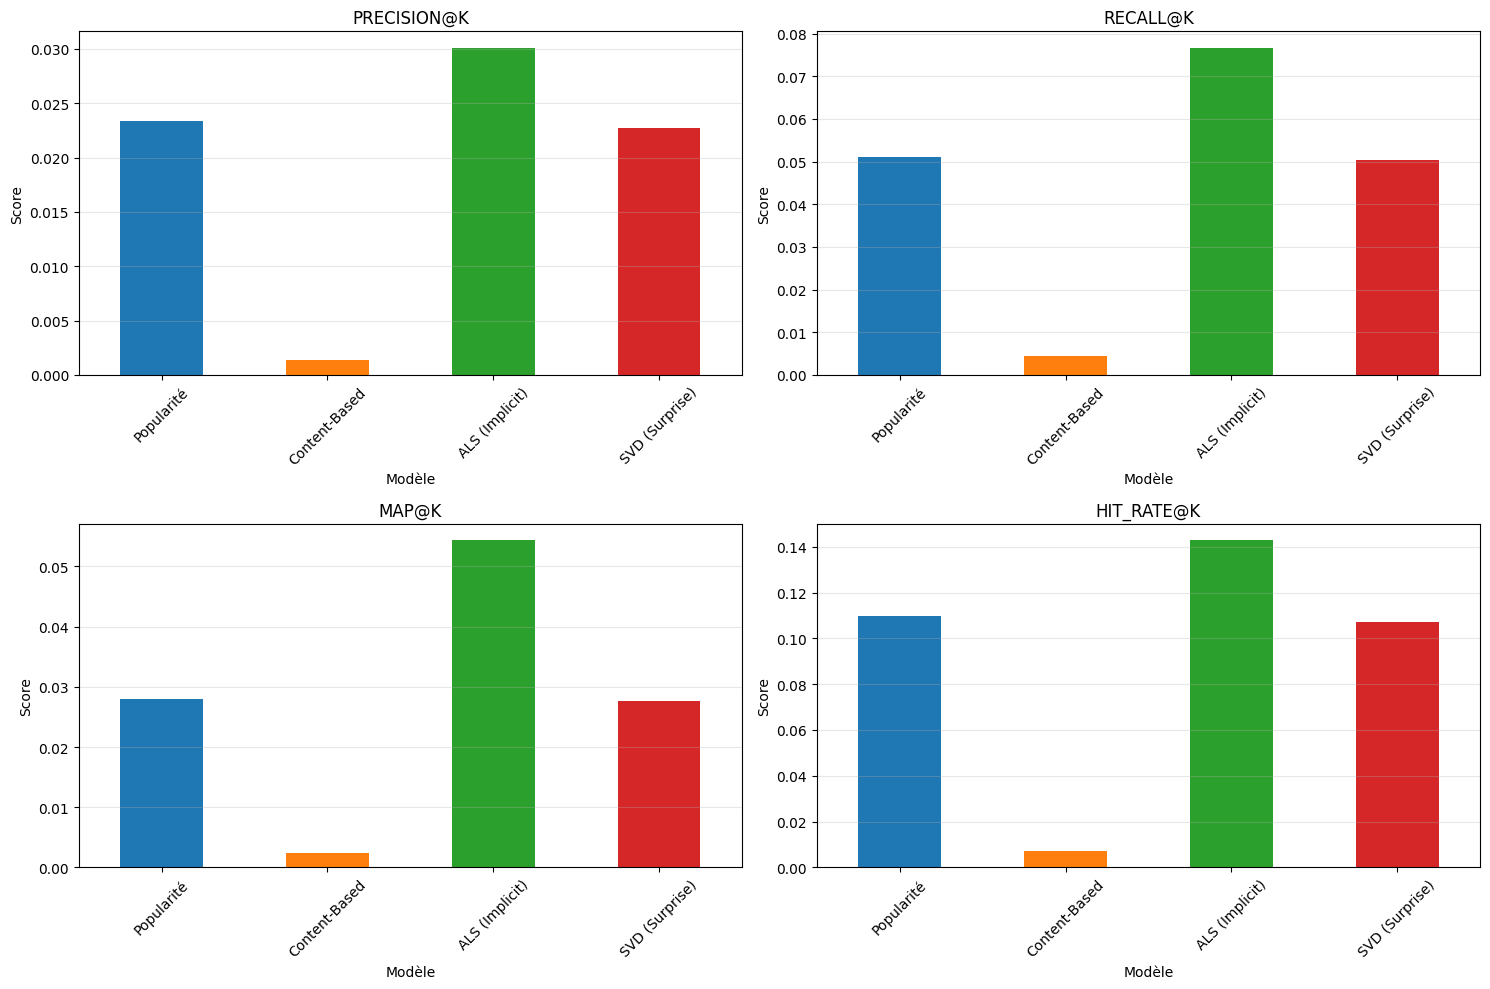

In [67]:
# Créer un DataFrame de comparaison (inclure SVD seulement s'il est disponible)
comparison_dict = {
    'Popularité': popularity_results,
    'Content-Based': content_based_results,
    'ALS (Implicit)': als_results
}

# Ajouter SVD seulement s'il est disponible
if svd_results.get('n_users', 0) > 0:
    comparison_dict['SVD (Surprise)'] = svd_results

comparison_df = pd.DataFrame(comparison_dict).T

print("=== COMPARAISON DES MODÈLES ===")
print(comparison_df.round(4))

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['precision@k', 'recall@k', 'map@k', 'hit_rate@k']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df[metric].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_title(f'{metric.upper()}')
    ax.set_ylabel('Score')
    ax.set_xlabel('Modèle')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Contrôle qualitatif


In [ ]:
def display_user_recommendations(user_id, models_dict, train_interactions, articles, test_user_items):
    """Affiche les recommandations pour un utilisateur avec les différents modèles"""
    print(f"\n{'='*80}")
    print(f"UTILISATEUR ID: {user_id}")
    print(f"{'='*80}")
    
    # Historique de l'utilisateur
    user_history = train_interactions[train_interactions['user_id'] == user_id]['article_id'].tolist()
    print(f"\nArticles déjà lus par l'utilisateur ({len(user_history)}):")
    if len(user_history) > 0:
        for i, article_id in enumerate(user_history[:10], 1):  # Afficher max 10
            article_info = articles[articles['article_id'] == article_id]
            if len(article_info) > 0:
                cat = article_info.iloc[0]['category_id']
                words = article_info.iloc[0]['words_count']
                print(f"  {i}. Article {article_id} - Catégorie: {cat}, Mots: {words}")
    
    # Articles réellement lus dans le test
    if user_id in test_user_items:
        test_items = test_user_items[user_id]
        print(f"\nArticles lus dans le test ({len(test_items)}):")
        for i, article_id in enumerate(test_items[:10], 1):
            article_info = articles[articles['article_id'] == article_id]
            if len(article_info) > 0:
                cat = article_info.iloc[0]['category_id']
                words = article_info.iloc[0]['words_count']
                print(f"  {i}. Article {article_id} - Catégorie: {cat}, Mots: {words}")
    
    # Recommandations de chaque modèle
    print(f"\n{'─'*80}")
    print("RECOMMANDATIONS PAR MODÈLE:")
    print(f"{'─'*80}")
    
    for model_name, recommendations_dict in models_dict.items():
        if user_id in recommendations_dict:
            recommendations = recommendations_dict[user_id]
            print(f"\n{model_name}:")
            for i, article_id in enumerate(recommendations, 1):
                article_info = articles[articles['article_id'] == article_id]
                if len(article_info) > 0:
                    cat = article_info.iloc[0]['category_id']
                    words = article_info.iloc[0]['words_count']
                    is_in_test = "✓" if user_id in test_user_items and article_id in test_user_items[user_id] else "✗"
                    is_in_history = "✓" if article_id in user_history else "✗"
                    print(f"  {i}. Article {article_id} - Cat: {cat}, Mots: {words} [Test: {is_in_test}, Hist: {is_in_history}]")

# Sélectionner quelques utilisateurs pour l'analyse qualitative
sample_users = list(test_user_items.keys())[:5]

models_dict = {
    'Popularité': popularity_recommendations_dict,
    'Content-Based': content_based_recommendations_dict,
    'SVD': svd_recommendations_dict,
    'ALS': als_recommendations_dict
}

for user_id in sample_users:
    display_user_recommendations(user_id, models_dict, train_interactions, articles, test_user_items)



UTILISATEUR ID: 0

Articles déjà lus par l'utilisateur (6):
  1. Article 160158 - Catégorie: 281, Mots: 145
  2. Article 96755 - Catégorie: 209, Mots: 211
  3. Article 87205 - Catégorie: 186, Mots: 137
  4. Article 313996 - Catégorie: 431, Mots: 265
  5. Article 87224 - Catégorie: 186, Mots: 100
  6. Article 68866 - Catégorie: 136, Mots: 226

Articles lus dans le test (2):
  1. Article 157541 - Catégorie: 281, Mots: 280
  2. Article 233470 - Catégorie: 375, Mots: 292

────────────────────────────────────────────────────────────────────────────────
RECOMMANDATIONS PAR MODÈLE:
────────────────────────────────────────────────────────────────────────────────

Popularité:
  1. Article 160974 - Cat: 281, Mots: 259 [Test: ✗, Hist: ✗]
  2. Article 272143 - Cat: 399, Mots: 184 [Test: ✗, Hist: ✗]
  3. Article 336221 - Cat: 437, Mots: 158 [Test: ✗, Hist: ✗]
  4. Article 234698 - Cat: 375, Mots: 183 [Test: ✗, Hist: ✗]
  5. Article 123909 - Cat: 250, Mots: 240 [Test: ✗, Hist: ✗]

Content-Based:
  

## 12. Sélection du modèle final


In [ ]:
# Sélectionner le meilleur modèle basé sur MAP@5 (métrique principale pour la recommandation)
best_model_name = comparison_df['map@k'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'map@k']

print(f"=== MODÈLE FINAL SÉLECTIONNÉ ===")
print(f"Modèle: {best_model_name}")
print(f"MAP@5: {best_model_score:.4f}")
print(f"\nToutes les métriques pour ce modèle:")
print(comparison_df.loc[best_model_name])

# Fonction finale pour générer des recommandations
def get_recommendations(user_id, n_reco=5):
    """
    Fonction finale pour obtenir des recommandations pour un utilisateur
    
    Args:
        user_id: ID de l'utilisateur
        n_reco: Nombre de recommandations (défaut: 5)
    
    Returns:
        Liste de article_id recommandés
    """
    if best_model_name == 'Popularité':
        return popularity_recommendations[:n_reco]
    elif best_model_name == 'Content-Based':
        # Utiliser les profils précalculés
        if user_id in user_profiles:
            user_profile = user_profiles[user_id].reshape(1, -1)
            read_articles_set = user_read_articles[user_id]
            
            # Calculer les similarités avec tous les embeddings
            similarities = cosine_similarity(user_profile, embeddings)[0]
            
            # Masquer les articles déjà lus
            if len(read_articles_set) > 0:
                read_articles_array = np.array(list(read_articles_set))
                read_mask = np.isin(all_article_ids, read_articles_array)
                similarities[read_mask] = -np.inf
            
            # Trier et récupérer le top n_reco
            top_indices = np.argsort(similarities)[::-1][:n_reco]
            recommended_article_ids = [all_article_ids[idx] for idx in top_indices if similarities[idx] > -np.inf]
            
            if len(recommended_article_ids) < n_reco:
                recommended_article_ids.extend(popularity_recommendations[:n_reco-len(recommended_article_ids)])
            
            return recommended_article_ids[:n_reco]
        else:
            return popularity_recommendations[:n_reco]
    elif best_model_name == 'SVD (Surprise)':
        return get_svd_recommendations(user_id, svd_model, trainset, n_reco)
    elif best_model_name == 'ALS (Implicit)':
        return get_als_recommendations(user_id, als_model, csr_train, user_to_idx, item_to_idx, unique_items, n_reco)
    else:
        return popularity_recommendations[:n_reco]

# Test avec quelques utilisateurs
print(f"\n=== TEST DU MODÈLE FINAL ({best_model_name}) ===")
test_user_ids = list(test_user_items.keys())[:3]
for user_id in test_user_ids:
    recommendations = get_recommendations(user_id, n_reco=5)
    print(f"\nUtilisateur {user_id}: {recommendations}")


=== MODÈLE FINAL SÉLECTIONNÉ ===
Modèle: ALS (Implicit)
MAP@5: 0.0544

Toutes les métriques pour ce modèle:
precision@k         0.030105
recall@k            0.076699
map@k               0.054366
hit_rate@k          0.142842
n_users        222861.000000
Name: ALS (Implicit), dtype: float64

=== TEST DU MODÈLE FINAL (ALS (Implicit)) ===

Utilisateur 0: [293114, 3, 160974, 272143, 336221]

Utilisateur 1: [284463, 3, 160974, 272143, 336221]

Utilisateur 2: [207122, 3, 160974, 272143, 336221]


## 13. Résumé et conclusions


In [ ]:
print("=== RÉSUMÉ DU SYSTÈME DE RECOMMANDATION ===")
print(f"\nDataset:")
print(f"  - Utilisateurs: {n_users:,}")
print(f"  - Articles: {n_items:,}")
print(f"  - Interactions: {n_interactions:,}")
print(f"  - Sparsité: {sparsity:.2%}")

print(f"\nModèles testés:")
for model_name in comparison_df.index:
    map_score = comparison_df.loc[model_name, 'map@k']
    hit_rate = comparison_df.loc[model_name, 'hit_rate@k']
    print(f"  - {model_name}: MAP@5={map_score:.4f}, Hit-Rate@5={hit_rate:.4f}")

print(f"\nModèle final sélectionné: {best_model_name}")
print(f"  MAP@5: {best_model_score:.4f}")
print(f"  Precision@5: {comparison_df.loc[best_model_name, 'precision@k']:.4f}")
print(f"  Recall@5: {comparison_df.loc[best_model_name, 'recall@k']:.4f}")
print(f"  Hit-Rate@5: {comparison_df.loc[best_model_name, 'hit_rate@k']:.4f}")

print(f"\n✅ Système MVP prêt: get_recommendations(user_id, n_reco=5)")


=== RÉSUMÉ DU SYSTÈME DE RECOMMANDATION ===

Dataset:
  - Utilisateurs: 322,897
  - Articles: 46,033
  - Interactions: 2,988,181
  - Sparsité: 99.98%

Modèles testés:
  - Popularité: MAP@5=0.0280, Hit-Rate@5=0.1099
  - Content-Based: MAP@5=0.0006, Hit-Rate@5=0.0038
  - ALS (Implicit): MAP@5=0.0544, Hit-Rate@5=0.1428
  - SVD (Surprise): MAP@5=0.0280, Hit-Rate@5=0.1099

Modèle final sélectionné: ALS (Implicit)
  MAP@5: 0.0544
  Precision@5: 0.0301
  Recall@5: 0.0767
  Hit-Rate@5: 0.1428

✅ Système MVP prêt: get_recommendations(user_id, n_reco=5)


## 14. Serialiser Artefacts

In [ ]:
!python serialize_artifacts.py

=== SÉRIALISATION DES ARTEFACTS ===

1. Chargement des données...
2. Création des interactions...
3. Séparation train/test...
4. Création de la matrice sparse...
   Matrice shape: (322897, 41125)
   Utilisateurs: 322,897
   Articles: 41,125

5. Entraînement du modèle ALS...
/Users/nicolaspages/Formation OpenClassRooms Ingénieur IA/P10/.venv/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 14 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|███████████████████████████████████████████| 15/15 [00:09<00:00,  1.60it/s]
   ✅ Modèle entraîné

6. Calcul des articles populaires (fallback)...
   Top 5 articles: [160974, 272143, 336221, 234698, 123909]

7. Sérialisation des artefacts...
   ✅ Artefacts sauv

## 15. Tester fonctions de recommandation "Recommender"

In [ ]:
from recommender import Recommender
recommender = Recommender("artifacts.pkl")
print(recommender.recommend(user_id=0))

[293114, 3, 160974, 272143, 336221]
